In [1]:
import numpy as np
from demod import DemodImpl
from decode import DecodeImpl
from encode import EncodeImpl
from mod import ModImpl
import matplotlib.pyplot as plt
import torch
from messages import messages

In [6]:
sf = 8
demod = DemodImpl(sf,fs_bw_ratio=8,fft_factor=16)
decode = DecodeImpl(sf)
enc = EncodeImpl(sf)
mod = ModImpl(sf)

In [22]:
def plot_spectrogram_from_stft(stft_results,file_name='sample_stft.pdf'):
    # Compute magnitude of STFT results
    magnitude = torch.abs(stft_results)
 
    # Convert to dB scale
    magnitude_dB = 20 * torch.log10(magnitude + 1e-6)  # Adding a small value to avoid log(0)
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.imshow(magnitude_dB.numpy(), aspect='auto', origin='lower', cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.ylabel('Frequency Bin')
    plt.xlabel('Time Frame')
    # plt.ylim(y_min,y_max)
    plt.tight_layout()
    plt.show()

def spec_to_network_input_complex(x):
    trim_size = demod.d_num_symbols // 2
    
    # Adjusting for single input, no batch dimension
    y = torch.cat((x[-trim_size:, :], x[:trim_size, :]), dim=0)

    y_abs_max = torch.max(torch.abs(y).view(-1), dim=0)[0].view(1, 1)
    y = y / y_abs_max
    return y


In [8]:
stft_nfft = demod.d_num_samples
stft_window = demod.d_num_symbols//2
hop_length = stft_window // 2
freq_size = demod.d_num_symbols

### Exploring End-to-End Encoding, Modulation, Demodulation and Decoding for sample LoRaPHY packets

First, we consider random payload stored in messages.

In [12]:
i = np.random.randint(0, len(messages))
message = messages[i]
print("Message: ", message)

Message:  [92, 63, 149, 201, 156, 74, 140, 48]


Now, let us encode the message:

In [14]:
encoded = enc.encode(message)
print("Encoded: ", encoded)

Encoded:  [225, 113, 1, 125, 1, 37, 13, 117, 77, 208, 58, 223, 61, 68, 198, 76, 143, 202, 1, 253, 127, 192, 96]


Next, the encoded message is modulated. Essentially, the encoded message presents the symbol ID for each target symbol in the packet.

In [34]:
sig = mod.modulate(encoded)

The modulated signal can be visualised as below:

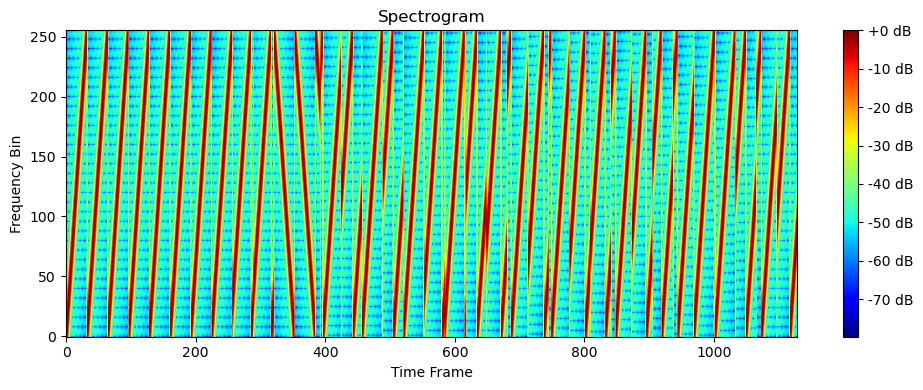

In [35]:
stft_results = torch.stft(torch.tensor(sig), n_fft=stft_nfft, hop_length=hop_length, win_length=stft_window, return_complex=True, pad_mode='constant',window=torch.hamming_window(stft_window))
stft_results = spec_to_network_input_complex(stft_results)
plot_spectrogram_from_stft(stft_results)

We can visualise the packet seperating the preamble, SFD, payload symbols

In [39]:
preamble = sig[:int(demod.d_num_samples*8)]
sfd = sig[int(demod.d_num_samples*10):int(demod.d_num_samples*12.25)]
payload = sig[int(demod.d_num_samples*12.25):]
sample_symbol = sig[int(demod.d_num_samples*13.25):int(demod.d_num_samples*14.25)]

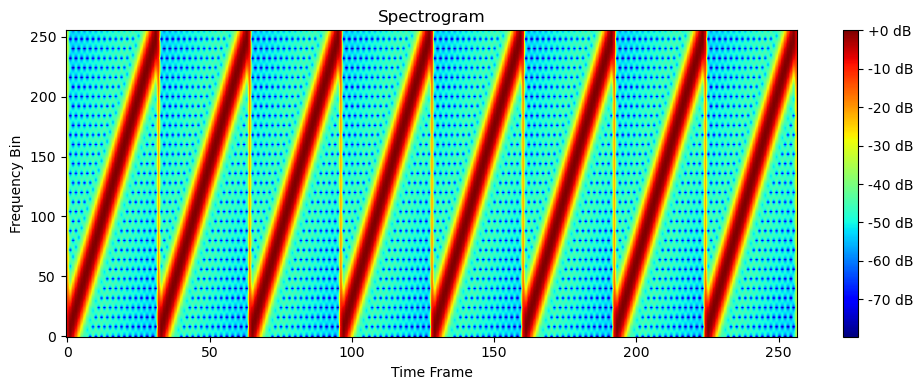

In [40]:
# Preamble
stft_results = torch.stft(torch.tensor(preamble), n_fft=stft_nfft, hop_length=hop_length, win_length=stft_window, return_complex=True, pad_mode='constant',window=torch.hamming_window(stft_window))
stft_results = spec_to_network_input_complex(stft_results)
plot_spectrogram_from_stft(stft_results)

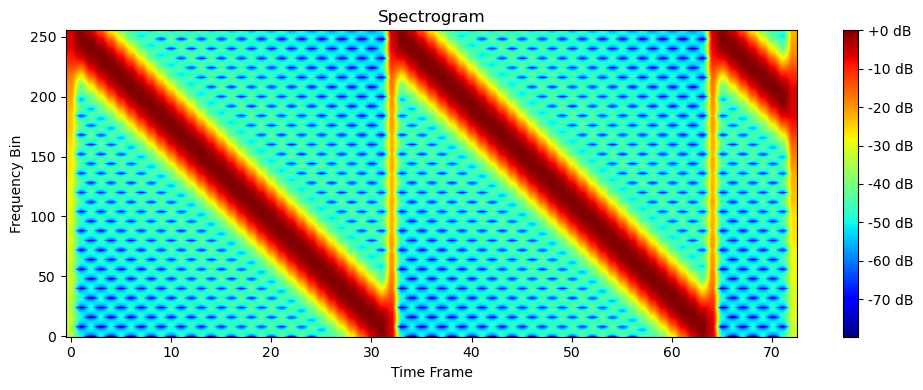

In [41]:
# SFD
stft_results = torch.stft(torch.tensor(sfd), n_fft=stft_nfft, hop_length=hop_length, win_length=stft_window, return_complex=True, pad_mode='constant',window=torch.hamming_window(stft_window))
stft_results = spec_to_network_input_complex(stft_results)
plot_spectrogram_from_stft(stft_results)

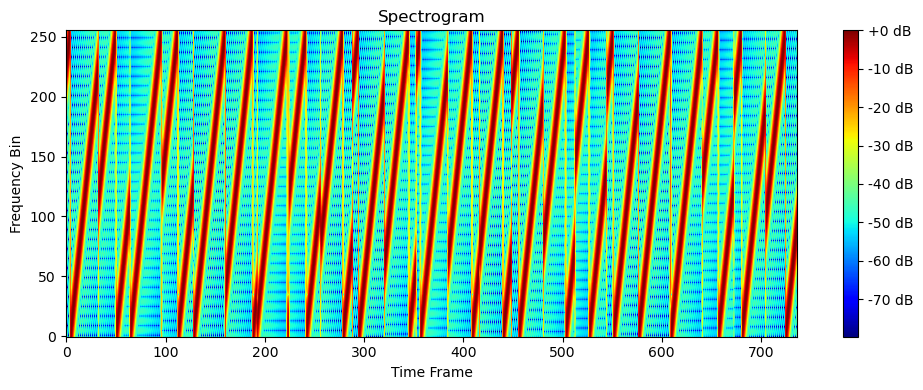

In [42]:
# Payload
stft_results = torch.stft(torch.tensor(payload), n_fft=stft_nfft, hop_length=hop_length, win_length=stft_window, return_complex=True, pad_mode='constant',window=torch.hamming_window(stft_window))
stft_results = spec_to_network_input_complex(stft_results)
plot_spectrogram_from_stft(stft_results)

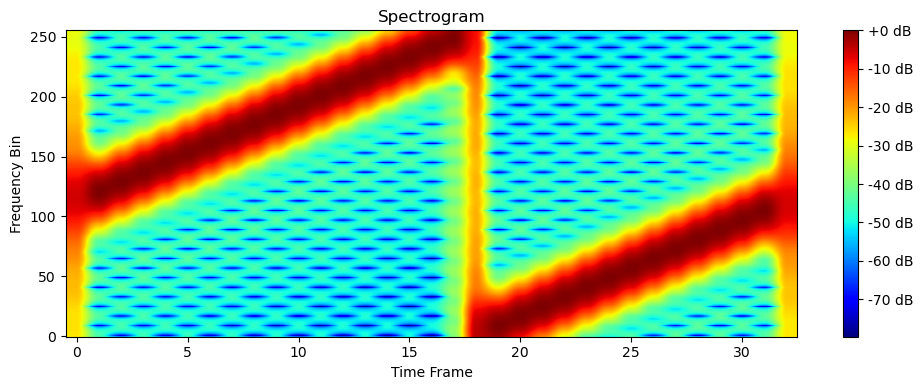

In [43]:
#Sample Symbol
stft_results = torch.stft(torch.tensor(sample_symbol), n_fft=stft_nfft, hop_length=hop_length, win_length=stft_window, return_complex=True, pad_mode='constant',window=torch.hamming_window(stft_window))
stft_results = spec_to_network_input_complex(stft_results)
plot_spectrogram_from_stft(stft_results)

Now let us Demodulate the Signal

In [58]:
demod_sig = demod.general_work_2(sig)

Note that the demodulated signal corresponds to the ID's of each symbol, i.e. the encoded message

In [59]:
demod_sig == encoded

True

Finally, we decode to find the payload

In [51]:
header_check,payload_check,decoded_message = decode.general_work(demod_sig)

In [53]:
# Header Checksum
header_check

True

In [54]:
#Payload Checksum
payload_check

True

In [55]:
decoded_message

[8, 48, 0, 92, 63, 149, 201, 156, 74, 140, 48, 228, 232]

In [56]:
decoded_message[3:-2] == message

True

Let us also try to demodulate our sample symbol:

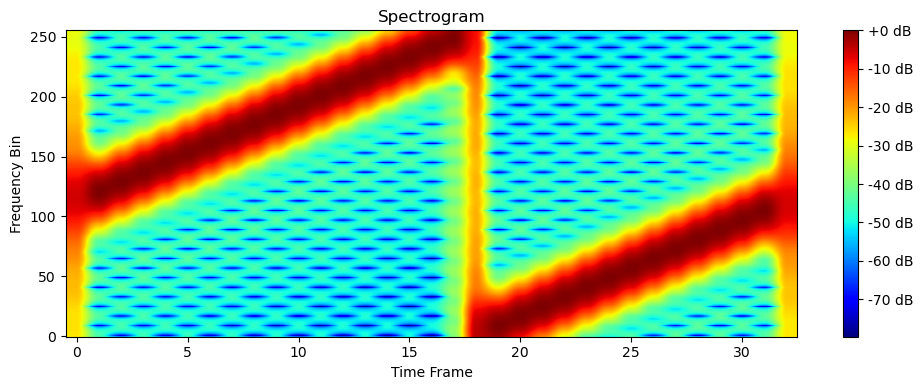

In [60]:
plot_spectrogram_from_stft(stft_results)

In [63]:
def fpmod(x, n):
    return (x % n + n) % n

dechirped = demod.dechirp(sample_symbol)
fft_result = demod.get_fft(dechirped)
max_idx = demod.search_fft_peak(fft_result)
bin_idx = np.round(fpmod((max_idx) / demod.d_fft_size_factor, demod.d_num_symbols))

In [64]:
bin_idx

113.0